In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import explain.run_tfmodisco as run_tfmodisco
import modisco
import h5py
import pyfaidx
import re
from modisco.visualization import viz_sequence
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TF-MoDISco is using the TensorFlow backend.
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
tf_name = "SPI1"
task_name = "SPI1_ENCSR000BGQ_GM12878"
region_size = 400

In [3]:
base_dir = os.path.join("/users/amtseng/tfmodisco/motifs/", tf_name)
shap_scores_path = os.path.join(base_dir, "tfmodisco/%s_scores.h5" % task_name)
tfm_results_path = os.path.join(base_dir, "tfmodisco/%s_tfm.h5" % task_name)

homer_peak_results_path = os.path.join(base_dir, "homer/from_peaks/%s" % task_name)
homer_seqlet_results_path = os.path.join(base_dir, "homer/from_seqlets/%s" % task_name)
meme_peak_results_path = os.path.join(base_dir, "meme/from_peaks/%s" % task_name)
meme_seqlet_results_path = os.path.join(base_dir, "meme/from_seqlets/%s" % task_name)

In [4]:
background_freqs = np.array([0.27, 0.23, 0.23, 0.27])

In [5]:
def import_tfmodisco_results(reference_fasta, shap_scores_path, tfm_results_path, region_size=400):
    """
    Imports TF-MoDISco results into a Python object
    """
    hyp_scores, act_scores, input_seqs = run_tfmodisco.prepare_tfm_inputs(shap_scores_path, reference_fasta, region_size)
    track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
        task_names=["task0"],
        contrib_scores=act_scores,
        hypothetical_contribs=hyp_scores,
        one_hot=input_seqs
    )
    with h5py.File(tfm_results_path, "r") as f:
        tfm_results = modisco.tfmodisco_workflow.workflow.TfModiscoResults.from_hdf5(f, track_set=track_set)
        
    return tfm_results

In [6]:
def show_tfmodisco_results(tfm_results):
    """
    Shows all patterns in all metaclusters of the given TF-MoDISco results.
    """
    for metacluster_id, metacluster in tfm_results.metacluster_idx_to_submetacluster_results.items():
        print(metacluster_id)
        patterns = metacluster.seqlets_to_patterns_result.patterns
        for pattern in patterns:
            viz_sequence.plot_weights(viz_sequence.ic_scale(pattern["sequence"].fwd, background=background_freqs))

Importing hypothetical scores:   2%|▏         | 1/44 [00:00<00:04,  8.67it/s]

TF-MoDISco results


Computing 1-hot encoded sequences: 100%|██████████| 44/44 [00:37<00:00,  1.19it/s]


metacluster_0


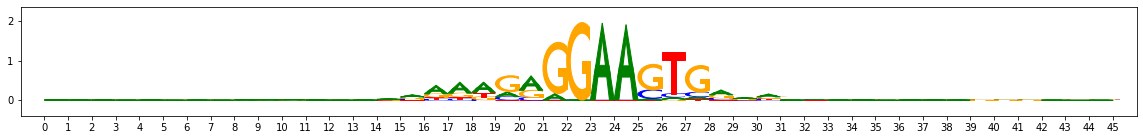

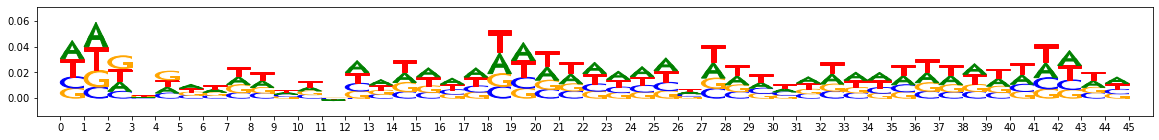

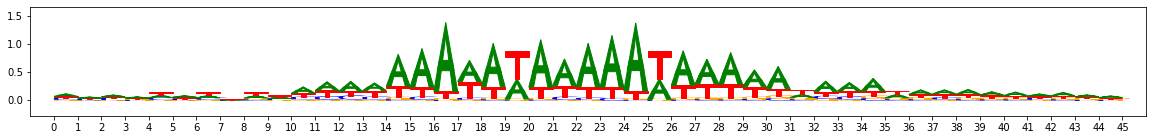

metacluster_1


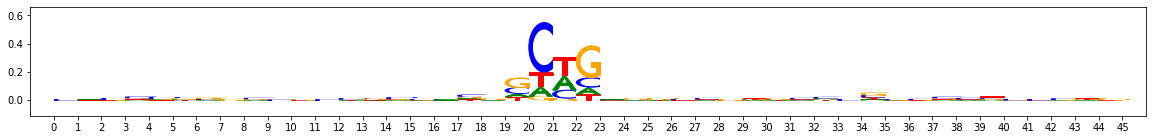

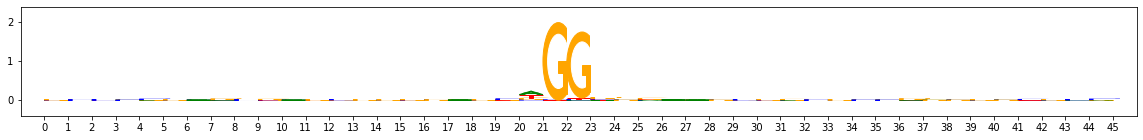

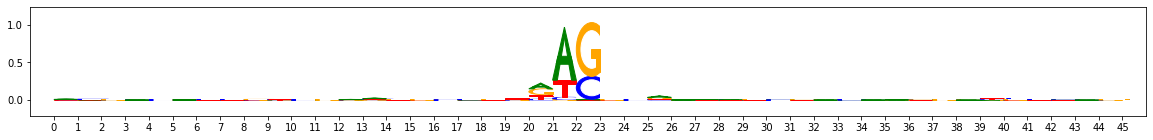

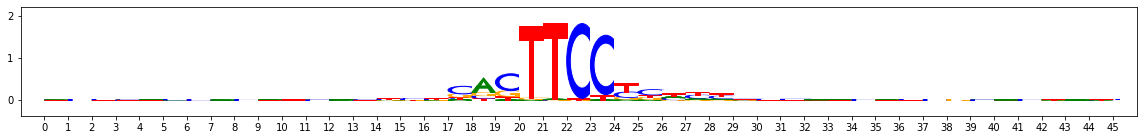

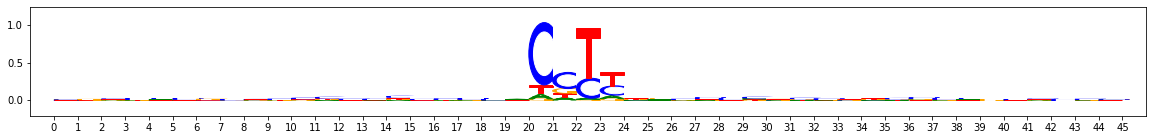

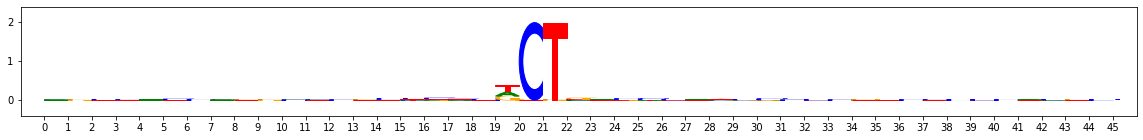

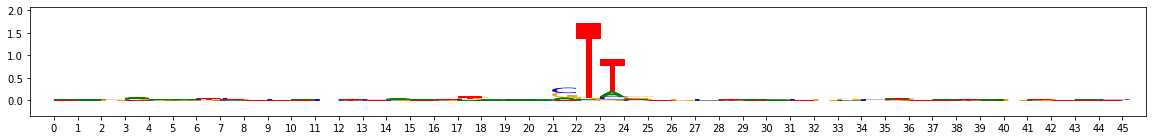

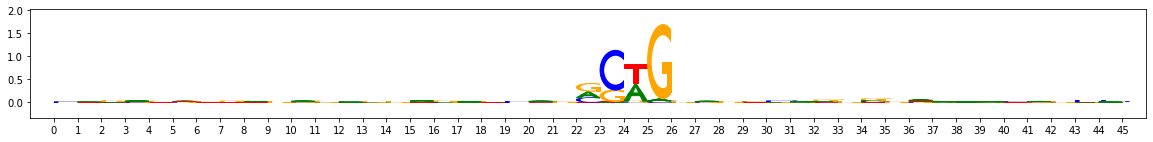

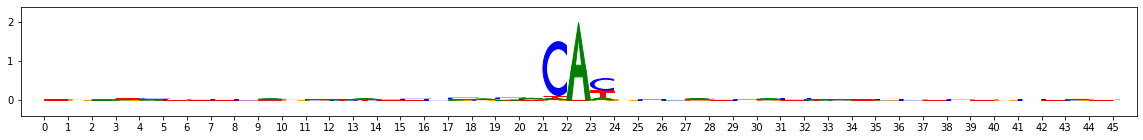

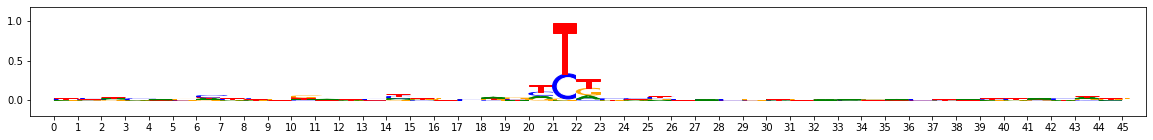

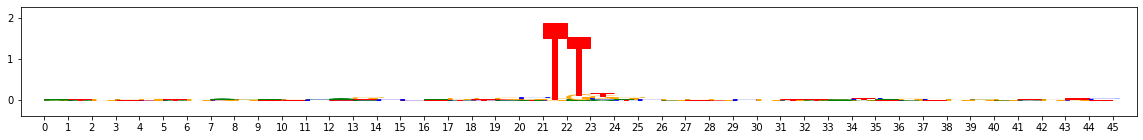

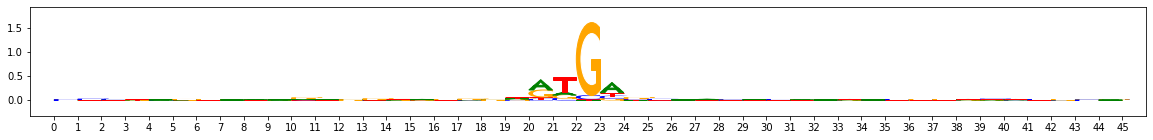

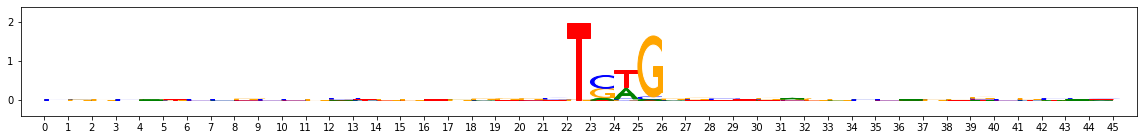

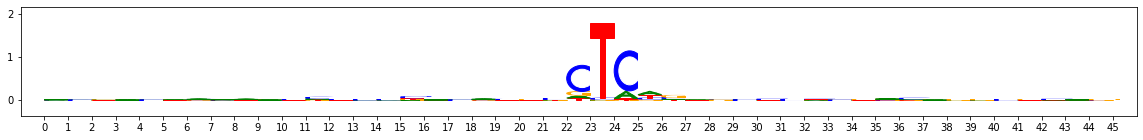

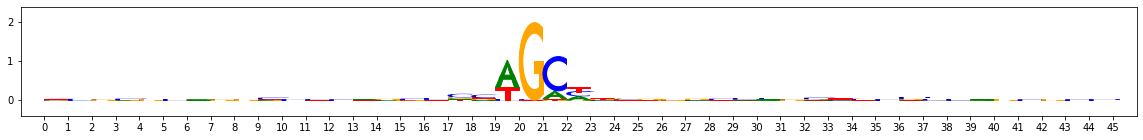

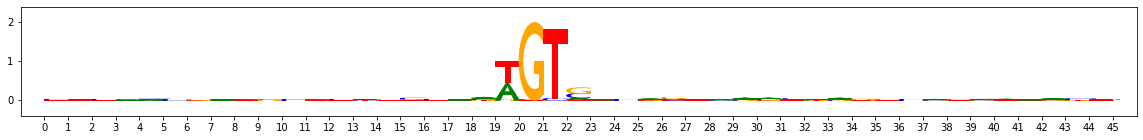

In [7]:
print("TF-MoDISco results")
tfm_results = import_tfmodisco_results(reference_fasta, shap_scores_path, tfm_results_path)
show_tfmodisco_results(tfm_results)

In [8]:
def show_meme_results(meme_results_path):
    logos = [item for item in os.listdir(meme_results_path) if item.endswith(".png")]
    num = len(logos) // 2
    
    with open(os.path.join(meme_results_path, "meme.txt"), "r") as f:
        evals = []
        for line in f:
            if line.startswith("MOTIF"):
                evals.append(line.strip().split()[-1])

    for i in range(1, num + 1):
        print("Logo %d, e-val = %s" % (i, evals[i - 1]))
        fwd_path = os.path.join(meme_results_path, "logo%d.png" % i)
        rev_path = os.path.join(meme_results_path, "logo_rc%d.png" % i)
        fwd = mpimg.imread(fwd_path)
        plt.figure()
        plt.imshow(fwd)
        plt.show()
        rev = mpimg.imread(rev_path)
        plt.figure()
        plt.imshow(rev)
        plt.show()

MEME from peaks
Logo 1, e-val = 7.1e-095


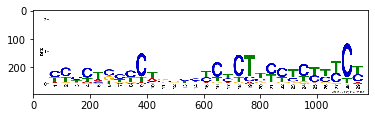

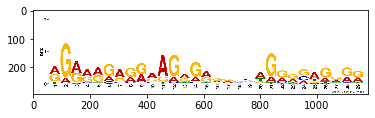

Logo 2, e-val = 6.7e-080


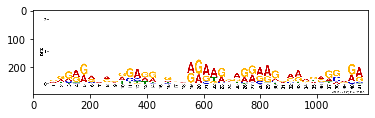

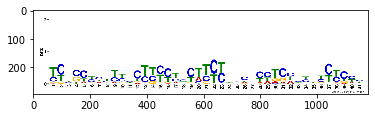

Logo 3, e-val = 1.1e-034


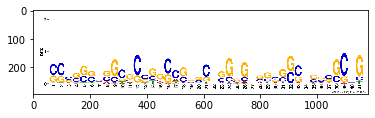

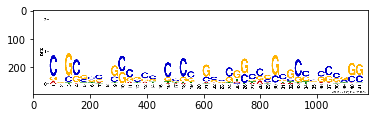

In [9]:
print("MEME from peaks")
show_meme_results(meme_peak_results_path)

MEME from seqlets
Logo 1, e-val = 4.1e-1251


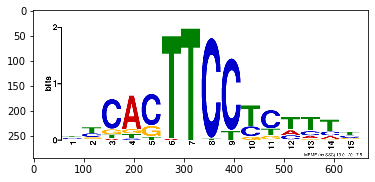

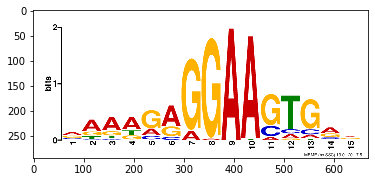

Logo 2, e-val = 2.8e-1225


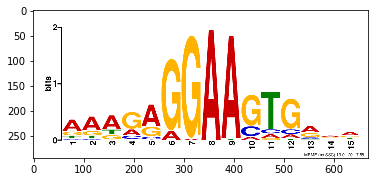

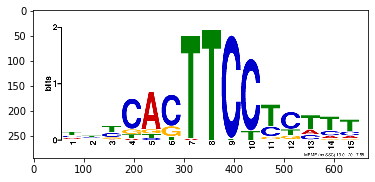

Logo 3, e-val = 2.3e-058


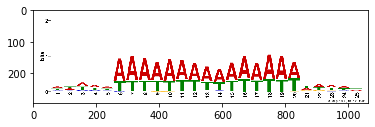

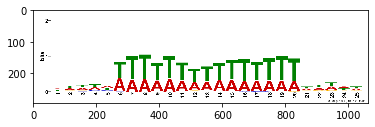

In [10]:
print("MEME from seqlets")
show_meme_results(meme_seqlet_results_path)

In [11]:
def show_homer_results(homer_results_path):
    denovo_dir = os.path.join(homer_results_path, "homerResults")
    pattern = re.compile(r"^motif\d+\.(logo|rvlogo)\.png$")
    logos = [item for item in os.listdir(denovo_dir) if pattern.match(item)]
    num = len(logos) // 2
    for i in range(1, num + 1):
        info_path = os.path.join(denovo_dir, "motif%d.motif" % i)
        with open(info_path, "r") as f:
            header = next(f).strip()
            tokens = header.split("\t")
            pval = tokens[5].split(",")[2].split(":")[1]
        print("Logo %d, p-val = %s" % (i, pval))
        fwd_path = os.path.join(denovo_dir, "motif%d.logo.png" % i)
        rev_path = os.path.join(denovo_dir, "motif%d.rvlogo.png" % i)
        fwd = mpimg.imread(fwd_path)
        plt.figure()
        plt.imshow(fwd)
        plt.show()
        rev = mpimg.imread(rev_path)
        plt.figure()
        plt.imshow(rev)
        plt.show()

HOMER from peaks
Logo 1, p-val = 1e-24449


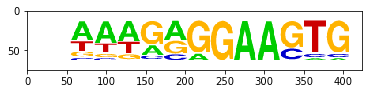

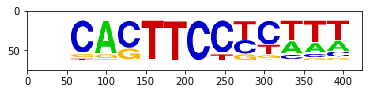

Logo 2, p-val = 1e-1502


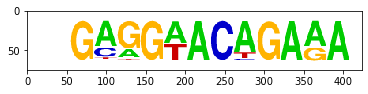

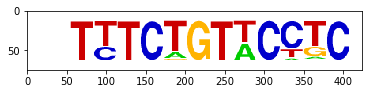

Logo 3, p-val = 1e-413


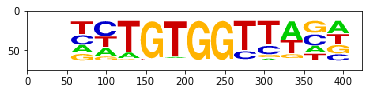

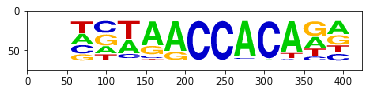

Logo 4, p-val = 1e-334


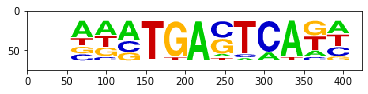

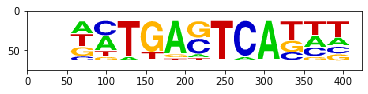

Logo 5, p-val = 1e-287


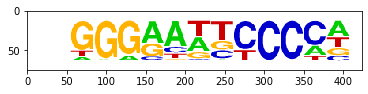

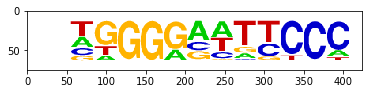

Logo 6, p-val = 1e-279


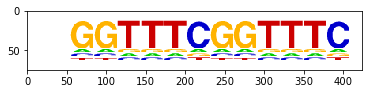

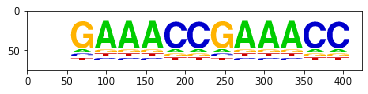

Logo 7, p-val = 1e-177


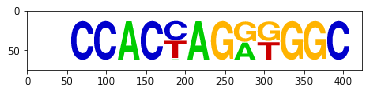

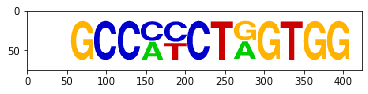

Logo 8, p-val = 1e-139


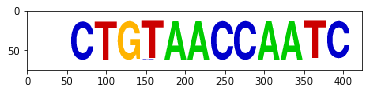

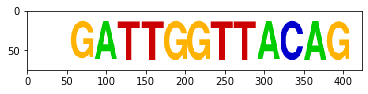

Logo 9, p-val = 1e-94


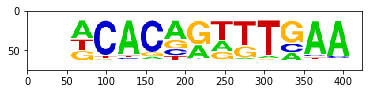

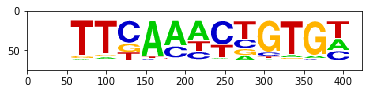

Logo 10, p-val = 1e-82


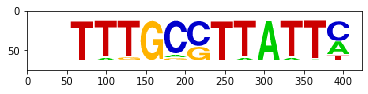

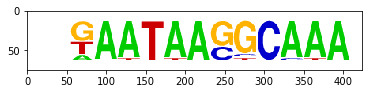

Logo 11, p-val = 1e-81


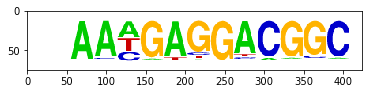

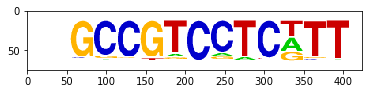

Logo 12, p-val = 1e-62


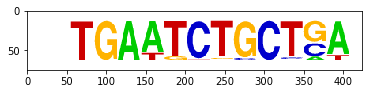

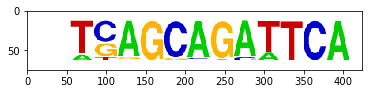

Logo 13, p-val = 1e-58


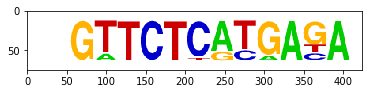

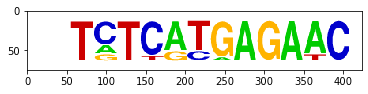

Logo 14, p-val = 1e-47


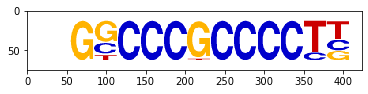

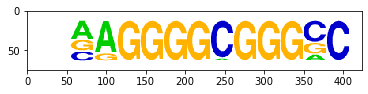

Logo 15, p-val = 1e-37


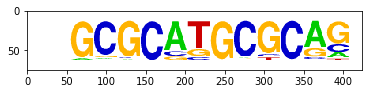

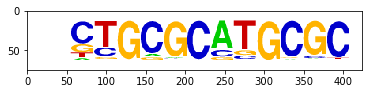

In [12]:
print("HOMER from peaks")
show_homer_results(homer_peak_results_path)

HOMER from seqlets
Logo 1, p-val = 1e-2759


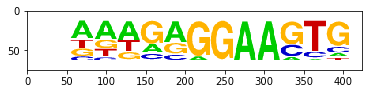

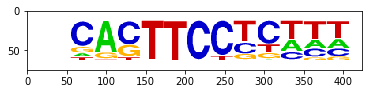

Logo 2, p-val = 1e-430


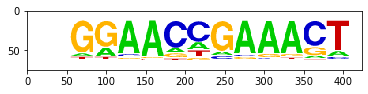

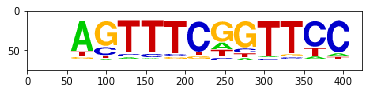

Logo 3, p-val = 1e-56


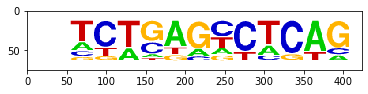

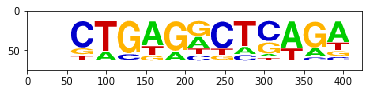

Logo 4, p-val = 1e-34


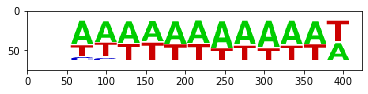

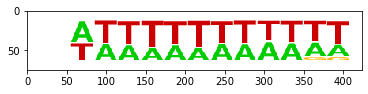

Logo 5, p-val = 1e-33


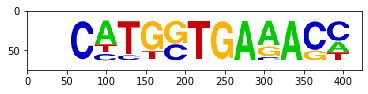

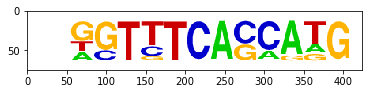

Logo 6, p-val = 1e-30


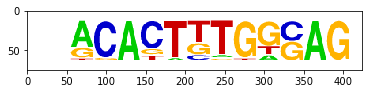

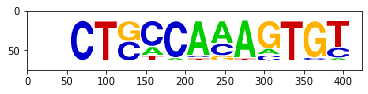

Logo 7, p-val = 1e-20


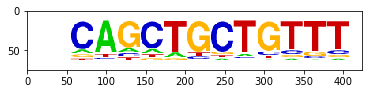

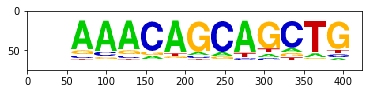

Logo 8, p-val = 1e-19


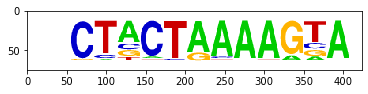

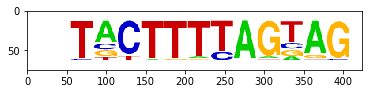

Logo 9, p-val = 1e-18


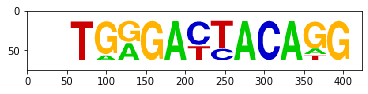

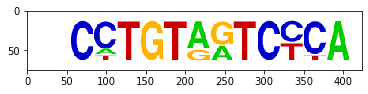

Logo 10, p-val = 1e-16


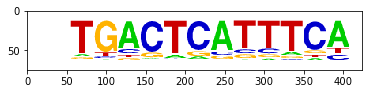

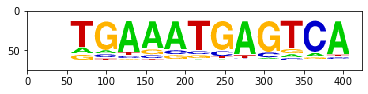

Logo 11, p-val = 1e-15


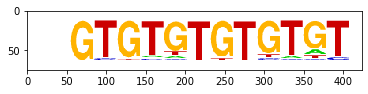

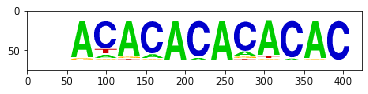

Logo 12, p-val = 1e-13


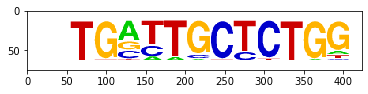

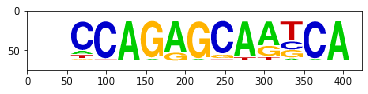

Logo 13, p-val = 1e-10


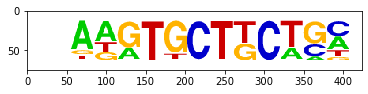

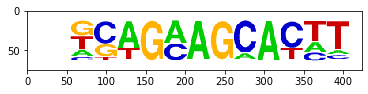

In [13]:
print("HOMER from seqlets")
show_homer_results(homer_seqlet_results_path)